# <center>**Elliptic Curve Cryptography**<center/>
## <center>**Joe Doyle**<center/>
---

## What is an Elliptic Curve?

### Elliptic Curve Fundamentals

An elliptic curve $E$ over a field $F$ is a collection of points $(x, y)$ where $x,y\in F$ satisfying the following equation:
$$y^2=x^3+ax+b$$
and containing the "point at infinity" $O$.

#### Identitites and Inverses

The point at infinity is the additive identity. That is, for all points $P\in F$, $P+O=P$

Let us also say that $P=(x, y)$. Then we will define $-P=(x,-y)$. We then say that $P+(-P)=O$

#### Addition

We define addition for two distinct points $P$ and $Q$ as $P+Q$ on an elliptic curve by first calculating the secant line between $P$ and $Q$. We then follow that line until it next intersects the curve. Let us call this point $J$. We then say that $P+Q=-J$. A graphical interpretation of addition is shown below:

<br/><br/>
<img src="images/addition_distinct.png" alt="Addition along an Elliptic Curve">
<br/><br/>

For point doubling ($2P=P+P$) we perform the same process but now with line tangent to the elliptic curve at point $P$ instead of the secant line.

### Elliptic Curves over Finite Fields

In the examples and images we looked at above, all calculations were done over the field of the real numbers, $\mathbb{R}$. However, for our purposes we will work exclusively with elliptic curves over the field $\mathbb{Z}/p\mathbb{Z}$ (the integers modulo a prime $p$). This means our elliptic curve equation above will now look like this:
$$y^2=x^3+ax+b\mod{p}$$
These finite fields are much easier for computers to work with, but are much less intuitive. Here is an example of an elliptic curve over a finite field:

<br/><br/>
<img src="images/finite_ec.png" alt="Elliptic Curve over finite field">
<br/><br/>

**Notice how not every x-coordinate contains a point on the elliptic curve.**

### Testing An Elliptic Curve

An elliptic curve implementation is available in the file `ec/elliptic_curve.py`. Let's test it out:

In [2]:
from ecc.ec.elliptic_curve import EllipticCurve

ModuleNotFoundError: No module named 'ecc'

In [7]:
# Define our Elliptic Curve
ecurve = EllipticCurve(0, 3, 23) # x^3 + 3x (mod 23)

# Define two of our points
p = (12, 11)
q = (1, 2)

# Print results from operations on Elliptic Curves with our points
print("P + O =", ecurve.add_points(p, ecurve.PTATINF)) # P + O
print("P + (Q - P) =", ecurve.add_points(p, ecurve.add_points(q, ecurve.neg(p)))) # P + (Q - P) should give Q


P + O = (12, 11)
P + (Q - P) = (1, 2)


---
## Uses of Elliptic Curves

There are many uses for elliptic curves and their math in cryptography, we'll go over the two that we chose to implement here: Elliptic Curve Diffie-Helmann and an Elliptic Curve El Gamal encryption-decryption system.

### Elliptic Curve Discrete Log Problem

The reason elliptic curves are useful is because of the difficulty of solving an elliptic curve "discrete log" problem. This discrete log term is not unique to elliptic curves, it exists in many forms. One of the most common is the RSA discrete log problem.

In RSA, public keys look like $g^b\mod{p}$. It is very hard to find the $b$ corresponding to a known public key, $g$, and $p$. This problem is known as the discrete log problem. It is the reason RSA is so hard to to crack.

In ECC, public keys look like $b\cdot P$. It turns out that it is also very hard to determine the $b$ corresponding to such a public key. This is known as the **Elliptic Curve Discrete Log Problem**, and is what makes elliptic curves cryptographically secure.

### Elliptic Curve Diffie-Helmann

The idea behind this is quite simple. Alice and Bob agree upon a curve $E$ and a point $P$ on that curve. Then they each choose a scalar private key which well call $a$ and $b$, respectively. Alice and Bob each compute their respective public keys $aP$ and $bP$, which are both points on the elliptic curve. Then Alice takes Bob's public key and forms the point $a(bP)$ while Bob uses Alice's public key to form the point $b(aP)$. Because the points on an elliptic curve form a group, $a(bP)=b(aP)$. This means that Alice and Bob will both end up with the same shared key without ever knowing the other person's private key.

Let's look at an example using our libraries. It is important to note that the `ECDH` classes randomly select a private key, which means this code is nondeterministic.

In [11]:
from ecc.ecdh import ECDH

In [12]:
new_ecurve = EllipticCurve(0, 3, 19) # y^2 = x^3 + 3 (mod 19)
p = (1, 2)

# for i in range(19):
#     print(i, new_ecurve.scalar_product(i, p))

alice = ECDH(p, new_ecurve)
bob = ECDH(p, new_ecurve)

a_pub = alice.get_public()
b_pub = bob.get_public()

print("Alice's public key: ", a_pub)
print("Bob's public key: ", b_pub)

print("Alice's shared key: ", alice.get_shared(b_pub))
print("Bob's shared key: ", bob.get_shared(a_pub))

Alice's public key:  (2, 12)
Bob's public key:  (14, 7)
Alice's shared key:  (1, 2)
Bob's shared key:  (1, 2)


### Elliptic Curve El-Gamal Cryptosystem

We start with an agreed upon elliptic curve $E$ and an agreed upon point $P$ with order $n$. Alice wishes to encrypt a point $T$ and send it to Bob who has public key $B$. Alice chooses an integer $a\in[0,n-1]$. Alice will then send a pair of points $(A, Y)$ where $A=a\cdot P$ (Alice's public key) and $Y=T+a\cdot B$ (point to encrypt + shared key).

Then Bob will receive a pair of points $(A, Y)$. He has also already chosen an integer $b\in[0, n-1]$ when he calculated $B=b\cdot P$ (his public key). He will then calculate $T=Y-b\cdot A$ (encrypted point - shared key), undoing the encryption operation Alice performed.

In [14]:
from ecc.ec_elgamal import ECActor

In [15]:
alice = ECActor(p, 13, new_ecurve) # 13p = O (point at infinity)
bob = ECActor(p, 13, new_ecurve)

# Calculate public keys for Alice and Bob
a_pub = alice.get_public()
b_pub = bob.get_public()

# Define the point we want to encrypt
to_encrypt = (11, 17)

# Have Alice encrypt the point
alice_encrypted = alice.encrypt(to_encrypt, b_pub)

# Have Bob encrypt the point
bob_encrypted = bob.encrypt(to_encrypt, a_pub)

# Print encrypted values
print("Alice's encrypted pair:", alice_encrypted)
print("Bob's encrypted pair:", bob_encrypted)

# Have Alice decrypt Bob's Encrypted values
alice_decrypted = alice.decrypt(bob_encrypted)

# Have Bob decrypt Alice's Encrypted values
bob_decrypted = bob.decrypt(alice_encrypted)

# Print decrypted values
print("Alice's decrypted value:", alice_decrypted)
print("Bob's decrypted value:", bob_decrypted)

Alice's encrypted pair: ((14, 12), (11, 17))
Bob's encrypted pair: ((0, 0), (11, 17))
Alice's decrypted value: (11, 17)
Bob's decrypted value: (11, 17)


---
## Taking an Object Oriented Approach

I took care to consolidate the elements of my cryptosystem into modular classes that each inhabit their own files. The UML Diagram that represents the classes making up this project is found below:



<img src="images/uml_diagram.png" alt="HomeRSA vs DES Time">

---
## Testing a Practical Elliptic Curve

Elliptic Curves and Elliptic Curve Cryptography is used widely in many situations requiring assymetric key exchanges, due to its advantages over RSA. These advantages include but are not limited to:

- Less memory usage (smaller keys + key compression)
- Faster
- More secure

One common usage of elliptic curves is in blockchain, where lots of asymmetric encryption/decryption operations need to be made extremely quickly. Bitcoin, for example, uses a specific elliptic curve known as `Secp256k1`, defined as $y^2=x^3+7\mod{p}$ where $p$ is an extremely large prime. Below, we create this curve using our defined classes.

In [19]:
# Define Secp256k1, the elliptic curve that Bitcoin uses. Parameters found here: https://en.bitcoin.it/wiki/Secp256k1

p = 0xFFFFFFFF_FFFFFFFF_FFFFFFFF_FFFFFFFF_FFFFFFFF_FFFFFFFF_FFFFFFFE_FFFFFC2F

ecurve = EllipticCurve(0, 7, p) # y^2 = x^2 + 7 (mod p)

Implementations of Secp256k1 also usually use an agreed-upon generator point `g`, which is defined below. This point also has a predefined order `ord_g`

In [21]:
# Define a generator point g and its order

g = (55066263022277343669578718895168534326250603453777594175500187360389116729240,
     32670510020758816978083085130507043184471273380659243275938904335757337482424)

ord_g = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEBAAEDCE6AF48A03BBFD25E8CD0364141

Now we will implement our Diffie-Hellman system using this curve and this point:

In [23]:
# Define actors alice and bob
alice = ECDH(g, ecurve)
bob = ECDH(g, ecurve)

# Calculate respective public keys for alice and bob
a_pub = alice.get_public()
b_pub = bob.get_public()

# Display their public keys
print("Alice public:", a_pub)
print("Bob public:", b_pub)
print()

# Calculate respective shared keys
a_share = alice.get_shared(b_pub)
b_share = bob.get_shared(a_pub)
print()

# Display their shared keys
print("Alice shared:", alice.get_shared(b_pub))
print("Bob shared:", bob.get_shared(a_pub))
print()

# Are their keys equal?
print("Are Alice and Bob's shared keys equal:", a_share == b_share)

Alice public: (108629317450522572251136874684335088369233471317489605553632955466280510379584, 72358629170881814577835349269198168648275740110070247484431175724914462690050)
Bob public: (15984370882032663267146863717562544504627444165074749908970731501099432907003, 5139123683284660511613724407047629075325221985457711952370660620238087809074)


Alice shared: (27612437625720277746419096830919095246600325285112209245281851848392432469654, 102840273571670798123855200284376622796729442091517680482091878793386794487163)
Bob shared: (27612437625720277746419096830919095246600325285112209245281851848392432469654, 102840273571670798123855200284376622796729442091517680482091878793386794487163)

Are Alice and Bob's shared keys equal: True


Now we will implement our El Gamal system on this curve, using the `EllipticCurve.random_point(self)` method to encrypt random points along our curve:

In [25]:
# Define our actors for our system using the generator point previously defined
alice_gamal = ECActor(g, ord_g, ecurve)
bob_gamal = ECActor(g, ord_g, ecurve)

# Calculate their respective public keys
a_pub = alice_gamal.get_public()
b_pub = bob_gamal.get_public()

# Display public keys
print("Alice's public:", a_pub)
print("Bob's public:", b_pub)
print()

# Generate and display a random point along the curve
to_encrypt = ecurve.random_point()
print("Encrypting: ", to_encrypt)
print()

# Have each of our actors encrypt our random point
alice_encrypt = alice_gamal.encrypt(to_encrypt, b_pub)
bob_encrypt = bob_gamal.encrypt(to_encrypt, a_pub)

# Display the encrypted values
print("Alice encrypted:", alice_encrypt)
print("Bob encrypted:", bob_encrypt)
print()

# Decrypt the other actors' encrypted values
alice_decrypt = alice_gamal.decrypt(bob_encrypt)
bob_decrypt = bob_gamal.decrypt(alice_encrypt)

# Display decrypted values
print("Alice decrypted: ", alice_decrypt)
print("Bob decrypted: ", bob_decrypt)
print()

# Assert that all the encrypted values are the same
print("Decrypted values match values to encrypt?", to_encrypt == alice_decrypt == bob_decrypt)

Alice's public: (10623622504415209626867932191185031996580021978528547138051270181852991851116, 60910882014378396329200088023943333376641988868750377065392736679959705003081)
Bob's public: (4468592596632355405001463523024233232274393664724973831138954930909111508683, 52259638144403301421292120036554625680181929393591560881094333072959421950016)

Encrypting:  (82124425889039402198298786597738133116957533929811593491899113628790769623417, 95370143332216812720847541991300607112689142901856702595468730217789251724930)

Alice encrypted: ((10623622504415209626867932191185031996580021978528547138051270181852991851116, 60910882014378396329200088023943333376641988868750377065392736679959705003081), (41241601479309793376225962713649146171338784619098412818170873213021253951232, 63563604284178499437852136165132081231149854980395710372853629008738616853103))
Bob encrypted: ((4468592596632355405001463523024233232274393664724973831138954930909111508683, 5225963814440330142129212003655462568018192939

---
## Testing Our Implementation

### Timing our Systems
Now that we have tested our implementation, we can determine how the speed of our model compares to other cryptosystems. We will begin by sampling and graphing the time to randomly generate a point, encrypt that point, and decrypt that point.

In [27]:
import time

In [28]:
tests = 100

gen_time = []
encrypt_time = []
decrypt_time = []

for i in range(tests):
    # Measure time to generate random point
    t = time.time()
    to_encrypt = ecurve.random_point()
    gen_time.append(time.time() - t)

    # Measure time to encrypt point
    t = time.time()
    encrypted = alice_gamal.encrypt(to_encrypt, b_pub)
    encrypt_time.append(time.time() - t)

    # Measure time to decrypt point
    t = time.time()
    decrypted = bob_gamal.decrypt(encrypted)
    decrypt_time.append(time.time() - t)

    assert to_encrypt == decrypted

Now we will take the averages of each of these arrays:

In [30]:
def avg(array):
    """
    Simple helper function to calculate average of an array
    """
    return sum(array) / len(array)

gen_avg = avg(gen_time)
encrypt_avg = avg(encrypt_time)
decrypt_avg = avg(decrypt_time)

In [31]:
import matplotlib.pyplot as plt

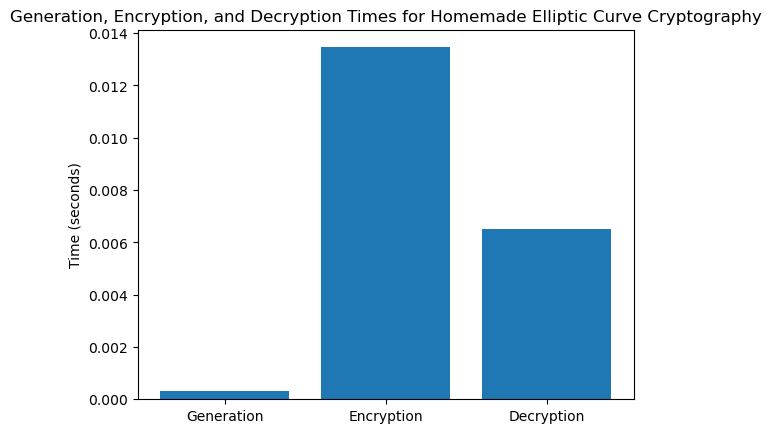

In [32]:
plt.bar(['Generation', 'Encryption', 'Decryption'], [avg(gen_time), avg(encrypt_time), avg(decrypt_time)])
plt.ylabel('Time (seconds)')
plt.title('Generation, Encryption, and Decryption Times for Homemade Elliptic Curve Cryptography')
plt.show()

Let's now look at how these times stack up to our homemade RSA and DES implementations: [Source of Graph](https://github.com/JoeDoyle12/RSAResearch)

<img src="images/HomeRSAvsDES.png" alt="HomeRSA vs DES Time">

### Time Testing Results

We see that our Elliptic Curve Cryptography System takes significantly longer than RSA and DES to encrypt data, but our elliptic curve decryption time is smaller than both RSA and DES. RSA is a common asymmetric cryptographic protocol, while DES is a common symmetric protocol. These results are promising, and show that our Elliptic Curve algorithm's speed is highly competitive.

## Conclusion

Elliptic Curves are powerful tools are widely used in asymmetric cryptosystems due to their difficult discrete log problem. The other files in this repository contain the classes used in these demonstrations, the EllipticCurve, ECDH, ECActor classes. They are all implemented entirely in Python.

It turns out that Quantum Computers are also adept at solving the Elliptic Curve discrete logarithm, using a modified Shor's algorithm. This means that Elliptic Curve Cryptography may be phased out soon in favor of cryptosystems resistant to quantum attacks.